Collaboration and Competition
---

In this notebook, you will test the installed Unity ML-Agents environment for the project.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 3. Import the necessary packages

In [5]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

## 4. Agent implementation
As seen above, the state and action spaces are continuous. Hence, value based methods such as DQN would not be directly applicable in this case. Moreover, this is a case of multi-agent learning. Hence, methods such as DDPG would not work. This notebook implements the Multi Agent Deep Deterministic Policy Gradients (MADDPG) method for training the agents.
<br>Please refer the maddpg_agent script for MetaAgent class.

In [6]:
%load_ext autoreload
%autoreload 2

In [12]:
import maddpg_agent 
import importlib

importlib.reload(maddpg_agent)
seed = 2
agent = maddpg_agent.MetaAgent(num_agents, seed, state_size, noise_start=0.5, t_stop_noise=30000)

In [8]:
n_episodes = 6000
max_t = 1000
scores = []
scores_deque = deque(maxlen=100)
scores_avg = []

for i_episode in range(1, n_episodes+1):
    rewards = []
    env_info = env.reset(train_mode=True)[brain_name]    # reset the environment    
    state = env_info.vector_observations                  # get the current state (for each agent)

    # loop over steps
    for t in range(max_t):
        # select an action
        action = agent.act(state)
        # take action in environment and set parameters to new values
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations
        rewards_vec = env_info.rewards
        done = env_info.local_done
        # update and train agent with returned information
        agent.step(state, action, rewards_vec, next_state, done)
        state = next_state
        rewards.append(rewards_vec)
        if any(done):
            break

    # calculate episode reward as maximum of individually collected rewards of agents
    episode_reward = np.max(np.sum(np.array(rewards),axis=0))
        
    scores.append(episode_reward)             # save most recent score to overall score array
    scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
    current_avg_score = np.mean(scores_deque)
    scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array
    
    print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score),end="")
    
    # log average score every 100 episodes
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score))
        agent.save_agents()

    # break and report success if environment is solved
    if np.mean(scores_deque)>=.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
        agent.save_agents()
        break

Episode 100	Average Score: 0.024
Episode 200	Average Score: 0.028
Episode 300	Average Score: 0.008
Episode 400	Average Score: 0.052
Episode 500	Average Score: 0.025
Episode 600	Average Score: 0.033
Episode 700	Average Score: 0.027
Episode 800	Average Score: 0.054
Episode 900	Average Score: 0.063
Episode 1000	Average Score: 0.100
Episode 1100	Average Score: 0.127
Episode 1200	Average Score: 0.466
Episode 1300	Average Score: 0.356
Episode 1400	Average Score: 0.443
Episode 1408	Average Score: 0.501
Environment solved in 1408 episodes!	Average Score: 0.501


### 5. Plot the rewards

In [9]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

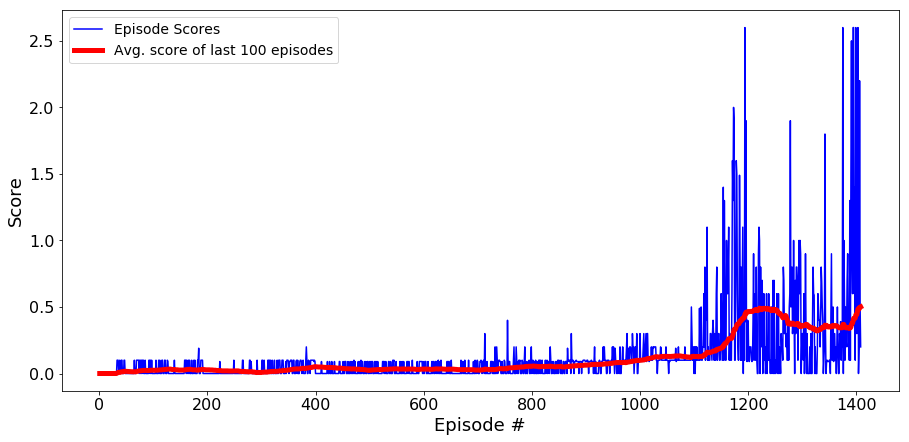

In [10]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,'b',label='Episode Scores')
plt.plot(np.arange(1, len(scores)+1), scores_avg,'r',\
         linewidth=5,label='Avg. score of last 100 episodes')
plt.ylabel('Score', fontsize=18)
plt.xlabel('Episode #', fontsize=18)
ax.legend(fontsize=14)
plt.show()

In [11]:
env.close()

## 6. Watch Smart Agents Play!